# Fit global epistasis models to DMS expression data

The [`dms_variants.globalepistasis`](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis) module is based off the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) -- that there exists an underlying latent phenotype that mutations affect additively, and
then an observed (measured) phenotype that is a non-linear
function of the latent phenotype.


## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import os
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

import yaml

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.4.7


Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [7]:
os.makedirs(config['global_epistasis_expr_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

## Read in Sort-seq expression mean fluorescence scores by `barcode`
Read in Sort-seq expression measurements. I will first fit global epistasis models using the ML_meanF measurements. Rename meanF column to be func_score, and var column to func_score_var. Remove rows with NaN for func_score. For empty aa_substitutions (wildtype), it is being replaced with NA. Make back to an empty string.

In [8]:
df = pd.read_csv(config['expression_sortseq_file'])
df.rename(columns={'ML_meanF':'func_score','var_ML_meanF':'func_score_var'},inplace=True)
func_scores = df[pd.notnull(df['func_score'])]
func_scores.fillna('',inplace=True)
func_scores.head()

,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,func_score,func_score_var,variant_class,aa_substitutions,n_aa_substitutions
0,1,libA2,191113,AAAAAAAAAAAACCAG,3,5.674660,7.677660,0.378455,>1 nonsynonymous,L86W G233E,2
1,2,libA2,191113,AAAAAAAAAAAAGGTA,1,10.465208,7.457067,0.292225,>1 nonsynonymous,L20T P182A,2
2,3,libA2,191113,AAAAAAAAAAACTCAA,3,11.976462,7.315538,0.276038,>1 nonsynonymous,N31S T71C G195K R199G D220G Q239C,6
5,6,libA2,191113,AAAAAAAAAATCCAAT,3,32.292764,9.245756,0.181542,1 nonsynonymous,V123F,1
6,7,libA2,191113,AAAAAAAAACAACACA,13,35.310214,7.692116,0.174819,>1 nonsynonymous,W47G V58G G195S,3


## Fit global epistasis models to ML meanF
We now fit global epistasis models to the functional scores.
For background on these models, see [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
The models we fits are implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html), which has extensive documentation.

The primary model of interest is [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis), which assumes that the observed phenotype is a monotonic non-linear function of an underlying additive latent phenotype.
As a control, we also fit a [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, which assumes that mutations simply contribute additively to the observed phenotype:

For the fitting, we first convert the set of functional scores into a binary representation using a [BinaryMap]((https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html#dms_variants.binarymap.BinaryMap)).
Then we create the model, fit it, and store it.

In [9]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (sample, lib), scores in func_scores.groupby(['sample',
                                                  'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, likelihoodtype, sample, lib)] = model

Fitting global epistasis with Gaussian likelihood model to 191113, libA2... fitting took 45.2 sec.
Fitting no epistasis with Gaussian likelihood model to 191113, libA2... fitting took 1.2 sec.
Fitting global epistasis with Cauchy likelihood model to 191113, libA2... fitting took 143.7 sec.
Fitting no epistasis with Cauchy likelihood model to 191113, libA2... fitting took 3.0 sec.
Fitting global epistasis with Gaussian likelihood model to 191215, libB2... fitting took 71.4 sec.
Fitting no epistasis with Gaussian likelihood model to 191215, libB2... fitting took 1.2 sec.
Fitting global epistasis with Cauchy likelihood model to 191215, libB2... fitting took 206.3 sec.
Fitting no epistasis with Cauchy likelihood model to 191215, libB2... fitting took 5.5 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better:

In [10]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, sample, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, sample, lib), model in models.items()],
            columns=['model', 'likelihood type', 'sample', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['sample', 'library'])
    )

logliks_df.round(1)

model likelihood type  n_parameters  log_likelihood       AIC
sample library                                                                          
191113 libA2    global epistasis        Gaussian          4658       -116396.2  242108.4
       libA2        no epistasis        Gaussian          4652       -129793.5  268890.9
       libA2    global epistasis          Cauchy          4658       -119382.3  248080.7
       libA2        no epistasis          Cauchy          4652       -136236.4  281776.8
191215 libB2    global epistasis        Gaussian          4671       -131391.3  272124.6
       libB2        no epistasis        Gaussian          4665       -152191.1  313712.3
       libB2    global epistasis          Cauchy          4671       -111961.8  233265.6
       libB2        no epistasis          Cauchy          4665       -142871.9  295073.8

In [11]:
# check to confirm the global epistasis model is better in all cases
assert (logliks_df
        .reset_index()
        .pivot_table(index=['sample', 'library'],
                     values='AIC',
                     columns='model'
                     )
        .assign(global_better=lambda x: x['global epistasis'] < x['no epistasis'])
        ['global_better']
        .all()
        )

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis models fit so much better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) models, below we are just going to analyze the results from the global epistasis model.

First, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.

In [12]:
# NBVAL_IGNORE_OUTPUT

variants_df = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, sample, lib), model in models.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

predictionsfile = os.path.join(config['global_epistasis_expr_dir'], 'globalepistasis_expression_predictions.csv')
variants_df.to_csv(predictionsfile, index=False)
print(f"Writing predictions to {predictionsfile}")

variants_df.head().round(2)

Writing predictions to results/global_epistasis_expression/globalepistasis_expression_predictions.csv


,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,likelihoodtype
0,L86W G233E,7.68,0.38,-2.87,7.31,191113,libA2,Gaussian
1,L20T P182A,7.46,0.29,-1.41,8.12,191113,libA2,Gaussian
2,N31S T71C G195K R199G D220G Q239C,7.32,0.28,-5.97,6.77,191113,libA2,Gaussian
3,V123F,9.25,0.18,-0.86,8.59,191113,libA2,Gaussian
4,W47G V58G G195S,7.69,0.17,-3.26,7.18,191113,libA2,Gaussian


Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

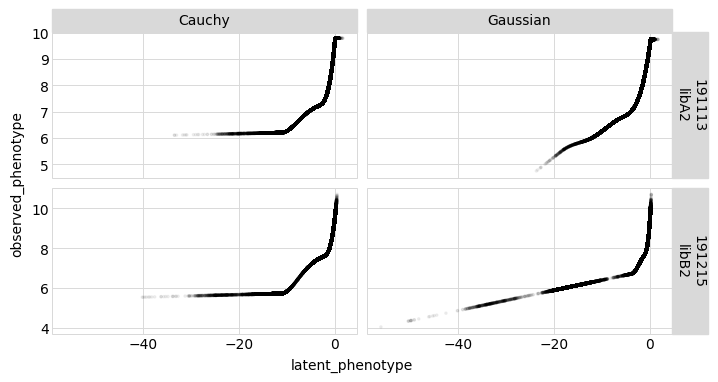

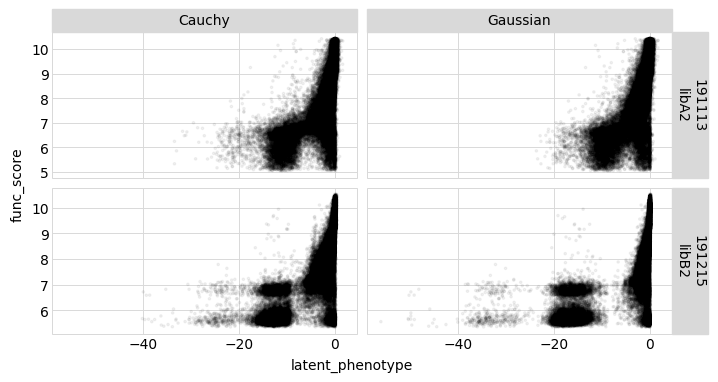

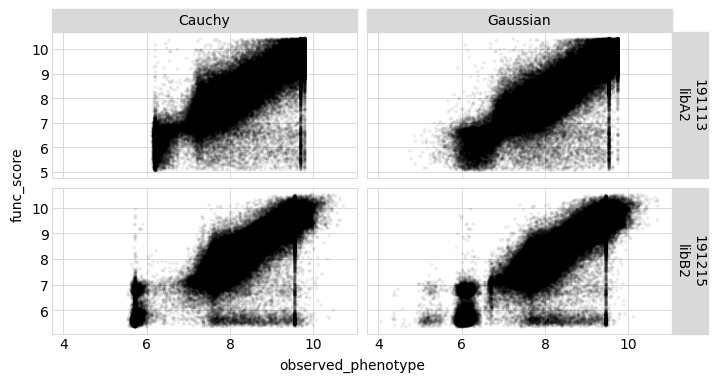

In [13]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library + sample ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * (variants_df['sample'].nunique()+variants_df['likelihoodtype'].nunique()),
                           2 * variants_df['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

Weird shapes in the range of very low expression phenotypes. There is bulk of points in the lower-right of the plots showing measured phenotype ("func_score") versus latent or predicted/observed phenotype, indicative of "false negatives" (that is, the model thinks they should be ~high expression, but experimentally, they were non-expressing). This is consistent with what I saw in the previous R script -- a handful of WT variants that had low expression, even with high sequencing counts (so, not noise). Some of these had high variant call support in PacBio sequencing, so they are likely veritable "WT" sequences -- I am assuming that they accrued mutations outside of the PacBio sequencing region (e.g. the Gibson junctions -- though I should check this, I believe these junctions are entirely within the PacBio window?) and are therefore truly nonexpressing, though not by virtue of their scFv genotype. It is therefore actually a *good* sign that the model is finding these points, and saying they actually do have high latent phenotypes despite their poor experimental expression.

I want to look at these curves for different types of mutants (i.e. single versus multiple mutants):

In [14]:
#add predicted and latent phenotypes to table by barcode with additional columns used for interpretation
dt = pd.read_csv(config['expression_sortseq_file'])
dt[['aa_substitutions']] = dt[['aa_substitutions']].fillna(value='')

dt = models.get(('global epistasis', 'Gaussian', 191113, 'libA2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_A',observed_phenotype_col='predicted_phenotype_Gaussian_A',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 191113, 'libA2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_A',observed_phenotype_col='predicted_phenotype_Cauchy_A',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Gaussian', 191215, 'libB2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_B',observed_phenotype_col='predicted_phenotype_Gaussian_B',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 191215, 'libB2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_B',observed_phenotype_col='predicted_phenotype_Cauchy_B',unknown_as_nan=True)



predictionsfile = os.path.join(config['global_epistasis_expr_dir'], 'globalepistasis_expression_predictions_wide.csv')
dt.to_csv(predictionsfile, index=False)
print(f"Writing predictions to {predictionsfile}")

dt.head().round(2)

Writing predictions to results/global_epistasis_expression/globalepistasis_expression_predictions_wide.csv


,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,ML_meanF,var_ML_meanF,variant_class,aa_substitutions,n_aa_substitutions,latent_phenotype_Gaussian_A,predicted_phenotype_Gaussian_A,latent_phenotype_Cauchy_A,predicted_phenotype_Cauchy_A,latent_phenotype_Gaussian_B,predicted_phenotype_Gaussian_B,latent_phenotype_Cauchy_B,predicted_phenotype_Cauchy_B
0,1,libA2,191113,AAAAAAAAAAAACCAG,3,5.67,7.68,0.38,>1 nonsynonymous,L86W G233E,2,-2.87,7.31,-2.31,7.39,-1.64,7.48,-2.28,7.60
1,2,libA2,191113,AAAAAAAAAAAAGGTA,1,10.47,7.46,0.29,>1 nonsynonymous,L20T P182A,2,-1.41,8.12,-1.08,8.14,-0.40,8.37,-0.62,8.51
2,3,libA2,191113,AAAAAAAAAAACTCAA,3,11.98,7.32,0.28,>1 nonsynonymous,N31S T71C G195K R199G D220G Q239C,6,-5.97,6.77,-4.35,7.14,-1.94,7.36,-3.42,7.47
3,4,libA2,191113,AAAAAAAAAAGCACTA,2,1.94,NaN,0.59,>1 nonsynonymous,D111I W173R,2,-1.04,8.42,-0.87,8.36,-0.51,8.18,-0.71,8.40
4,5,libA2,191113,AAAAAAAAAATAGTTA,1,5.00,NaN,0.40,1 nonsynonymous,L20T,1,-0.39,9.07,-0.30,9.15,-0.21,8.79,-0.24,9.08


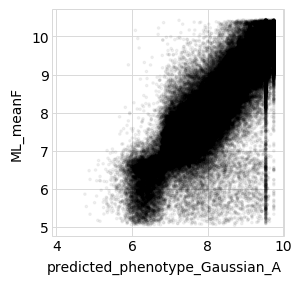

<ggplot: (-9223363276478718923)>

In [15]:
#all genotypes
(ggplot(dt[dt.library=='libA2'], aes('predicted_phenotype_Gaussian_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

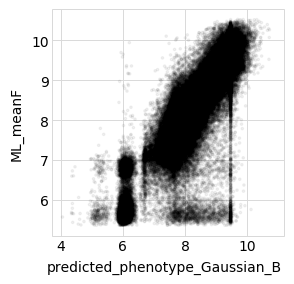

<ggplot: (8760380483918)>

In [16]:
#all genotypes
(ggplot(dt[dt.library=='libB2'], aes('predicted_phenotype_Gaussian_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

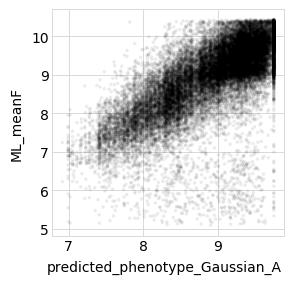

<ggplot: (8760372692982)>

In [17]:
#single mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Gaussian_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

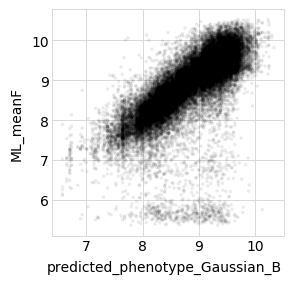

<ggplot: (-9223363276478773742)>

In [18]:
#single mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Gaussian_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

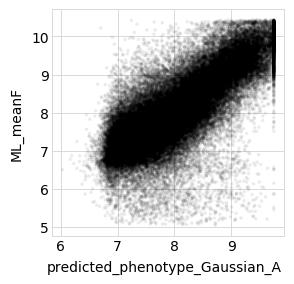

<ggplot: (8760364059270)>

In [19]:
#multiple mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == ">1 nonsynonymous"'), aes('predicted_phenotype_Gaussian_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

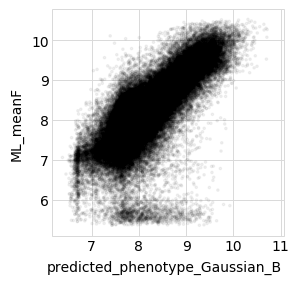

<ggplot: (-9223363276490472967)>

In [20]:
#multiple mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == ">1 nonsynonymous"'), aes('predicted_phenotype_Gaussian_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

Looks like many of the "weird" looking points are nonsense mutants

Look at same plots for fits with Cauchy likelihood

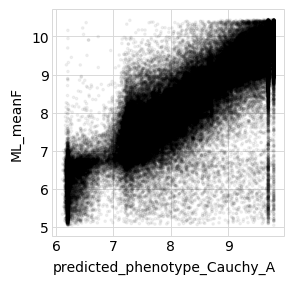

<ggplot: (-9223363276491822318)>

In [21]:
#all genotypes
(ggplot(dt[dt.library=='libA2'], aes('predicted_phenotype_Cauchy_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

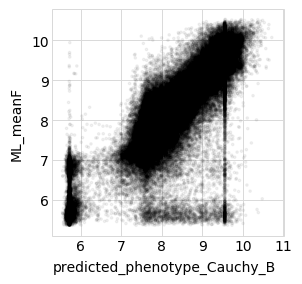

<ggplot: (8760361504334)>

In [22]:
#all genotypes
(ggplot(dt[dt.library=='libB2'], aes('predicted_phenotype_Cauchy_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

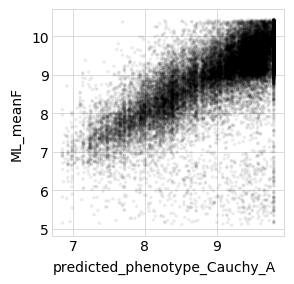

<ggplot: (-9223363276479860066)>

In [23]:
#single mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Cauchy_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

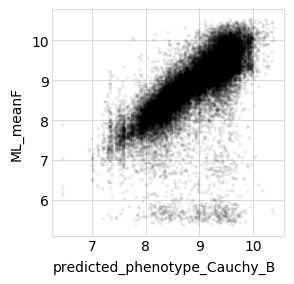

<ggplot: (-9223363276491737589)>

In [24]:
#single mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('predicted_phenotype_Cauchy_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

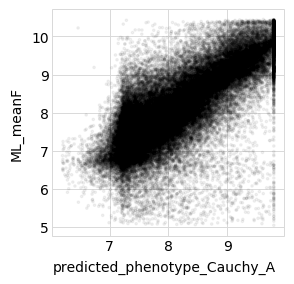

<ggplot: (-9223363276490296404)>

In [25]:
#multiple mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == ">1 nonsynonymous"'), aes('predicted_phenotype_Cauchy_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

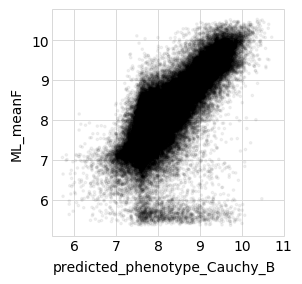

<ggplot: (-9223363276493888056)>

In [26]:
#multiple mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == ">1 nonsynonymous"'), aes('predicted_phenotype_Cauchy_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

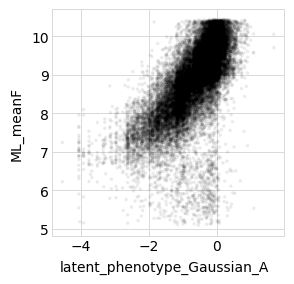

<ggplot: (-9223363276490359236)>

In [27]:
#look at meanF versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have specific epistasis)
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Gaussian_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

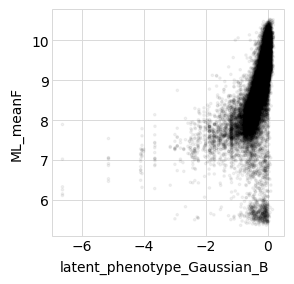

<ggplot: (8760364338054)>

In [28]:
#look at meanF versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have specific epistasis)
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Gaussian_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

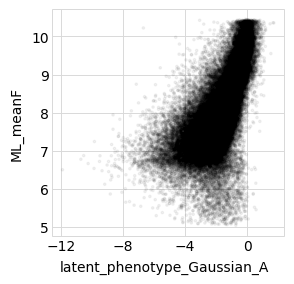

<ggplot: (8760363038258)>

In [29]:
#same plot as above but for multiple mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == ">1 nonsynonymous"'), aes('latent_phenotype_Gaussian_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

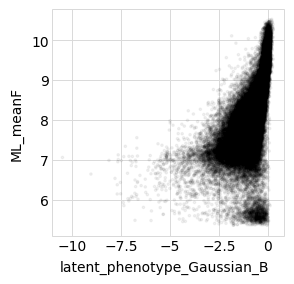

<ggplot: (8760360170742)>

In [30]:
#same plot as above but for multiple mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == ">1 nonsynonymous"'), aes('latent_phenotype_Gaussian_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

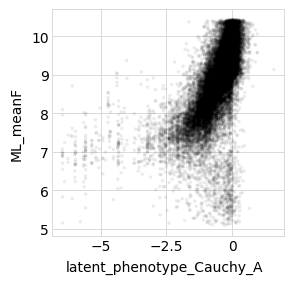

<ggplot: (8760376699256)>

In [31]:
#look at meanF versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have epistasis)
(ggplot(dt[dt.library=='libA2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Cauchy_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

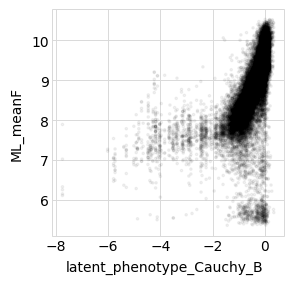

<ggplot: (8760389636570)>

In [32]:
#look at meanF versus latent phenotype for singles (gives better indicator of "shape" + noise than multiples which also have epistasis)
(ggplot(dt[dt.library=='libB2'].query('variant_class == "1 nonsynonymous"'), aes('latent_phenotype_Cauchy_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

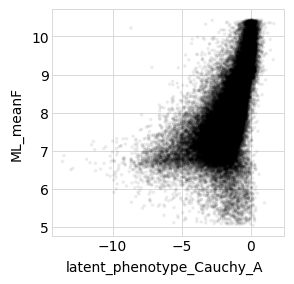

<ggplot: (8760374038420)>

In [33]:
#same plot as above but for multiple mutants
(ggplot(dt[dt.library=='libA2'].query('variant_class == ">1 nonsynonymous"'), aes('latent_phenotype_Cauchy_A', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

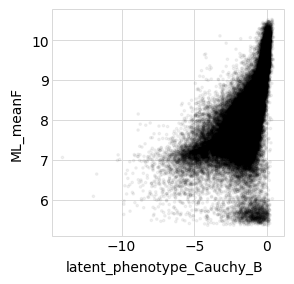

<ggplot: (8760380251782)>

In [34]:
#same plot as above but for multiple mutants
(ggplot(dt[dt.library=='libB2'].query('variant_class == ">1 nonsynonymous"'), aes('latent_phenotype_Cauchy_B', 'ML_meanF')) +
geom_point(alpha=0.05, size=0.5) +
theme(figure_size=(3,3))
)

Finally, looking at whether the points that deviate from the line are enriched for sites in close 3D proximity will help me tell the degree to which these are actual specific epistatic deviations versus errors.

## Repeat fits for ML_meanF without variance estimates on measured phenotypes

I want to see how the global epistasis models behave if I leave out the variance estimates.

In [35]:
func_scores_novar = func_scores.drop(columns='func_score_var')
func_scores_novar.head()

,Unnamed: 0,library,sample,barcode,variant_call_support,average_counts,func_score,variant_class,aa_substitutions,n_aa_substitutions
0,1,libA2,191113,AAAAAAAAAAAACCAG,3,5.674660,7.677660,>1 nonsynonymous,L86W G233E,2
1,2,libA2,191113,AAAAAAAAAAAAGGTA,1,10.465208,7.457067,>1 nonsynonymous,L20T P182A,2
2,3,libA2,191113,AAAAAAAAAAACTCAA,3,11.976462,7.315538,>1 nonsynonymous,N31S T71C G195K R199G D220G Q239C,6
5,6,libA2,191113,AAAAAAAAAATCCAAT,3,32.292764,9.245756,1 nonsynonymous,V123F,1
6,7,libA2,191113,AAAAAAAAACAACACA,13,35.310214,7.692116,>1 nonsynonymous,W47G V58G G195S,3


In [36]:
# NBVAL_IGNORE_OUTPUT

models_novar = {}  # store models, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (sample, lib), scores in func_scores_novar.groupby(['sample',
                                                        'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores,func_score_var_col=None)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models_novar[(epistasistype, likelihoodtype, sample, lib)] = model

Fitting global epistasis with Gaussian likelihood model to 191113, libA2... fitting took 42.8 sec.
Fitting no epistasis with Gaussian likelihood model to 191113, libA2... fitting took 0.3 sec.
Fitting global epistasis with Cauchy likelihood model to 191113, libA2... fitting took 111.4 sec.
Fitting no epistasis with Cauchy likelihood model to 191113, libA2... fitting took 3.6 sec.
Fitting global epistasis with Gaussian likelihood model to 191215, libB2... fitting took 41.3 sec.
Fitting no epistasis with Gaussian likelihood model to 191215, libB2... fitting took 0.8 sec.
Fitting global epistasis with Cauchy likelihood model to 191215, libB2... fitting took 242.7 sec.
Fitting no epistasis with Cauchy likelihood model to 191215, libB2... fitting took 8.4 sec.


In [37]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, sample, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, sample, lib), model in models_novar.items()],
            columns=['model', 'likelihood type', 'sample', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['sample', 'library'])
    )

logliks_df.round(1)

model likelihood type  n_parameters  log_likelihood       AIC
sample library                                                                          
191113 libA2    global epistasis        Gaussian          4658       -115316.8  239949.6
       libA2        no epistasis        Gaussian          4652       -129019.6  267343.2
       libA2    global epistasis          Cauchy          4658       -113233.3  235782.7
       libA2        no epistasis          Cauchy          4652       -133546.5  276397.0
191215 libB2    global epistasis        Gaussian          4671       -129271.4  267884.8
       libB2        no epistasis        Gaussian          4665       -149984.9  309299.9
       libB2    global epistasis          Cauchy          4671       -107507.3  224356.6
       libB2        no epistasis          Cauchy          4665       -140413.7  290157.3

In [38]:
# NBVAL_IGNORE_OUTPUT

variants_df_novar = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, sample, lib), model in models_novar.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

variants_df_novar.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,likelihoodtype
0,L86W G233E,7.68,None,-2.54,7.45,191113,libA2,Gaussian
1,L20T P182A,7.46,None,-1.36,8.14,191113,libA2,Gaussian
2,N31S T71C G195K R199G D220G Q239C,7.32,None,-5.64,6.85,191113,libA2,Gaussian
3,V123F,9.25,None,-0.86,8.57,191113,libA2,Gaussian
4,W47G V58G G195S,7.69,None,-3.19,7.22,191113,libA2,Gaussian


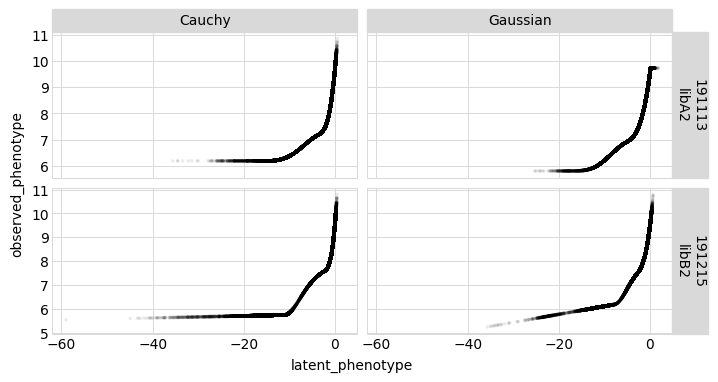

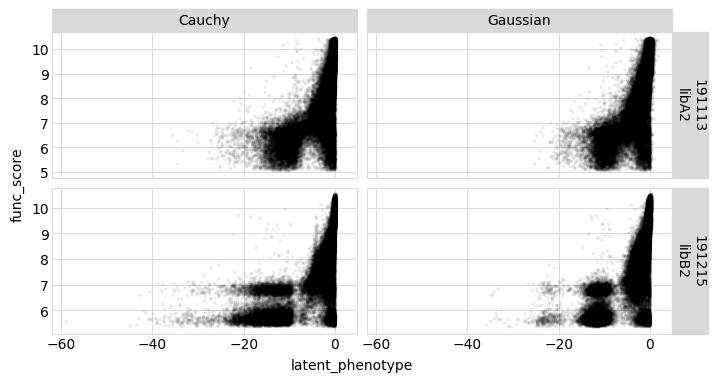

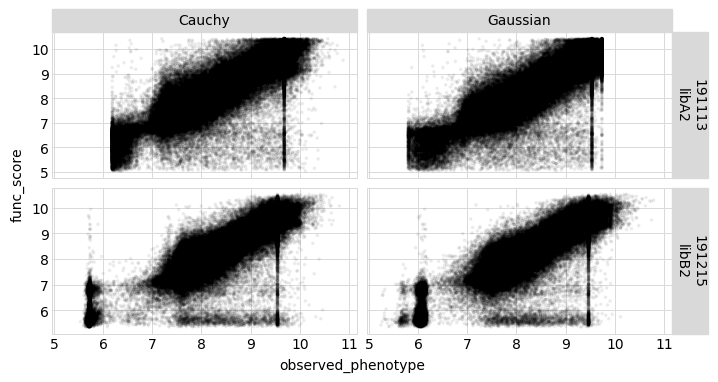

In [39]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_novar, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library + sample ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * (variants_df_novar['sample'].nunique()+variants_df_novar['likelihoodtype'].nunique()),
                           2 * variants_df_novar['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

Weird that they flip in terms of which likelihood interprets that decreases in meanF below ~6 correlate with decreased latent phenotype versus not. I haven't thought much about why that tail sometimes flat-lines versus continues to decrease, so I'm not really sure what this indicates anyway.

## We don't know the "true" phenotypes, but can we intuit if the global epistasis model is an improvement? 

Things we could look at: 
- Are predicted functional scores of the single mutants better correlated across replicates than the measured functional scores? 
- Are latent effects of mutations better correlated across replicates than the measured functional scores of single mutants?

Second replicate in progress........

## Output epistasis model parameters, preferences for logo plots

Until I can compare models built on two replicates, I will go ahead with both Gaussian and Cauchy likelihood model results.

In [40]:
#models.get(('global epistasis', 'Gaussian', 191113, 'libA2')).preferences(phenotype='latent',missing='site_average').to_csv('results/global_epistasis_expression/Gaussian-preferences-expression.csv', index=False)
#models.get(('global epistasis', 'Cauchy', 191113, 'libA2')).preferences(phenotype='latent',missing='site_average').to_csv('results/global_epistasis_expression/Cauchy-preferences-expression.csv', index=False)


Get dataframe of the beta coefficients from the epistasis model.

In [41]:
models.get(('global epistasis', 'Gaussian', 191113, 'libA2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_A.csv',index=False)
models.get(('global epistasis', 'Gaussian', 191113, 'libA2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_A.csv',index=False)
models.get(('global epistasis', 'Cauchy', 191113, 'libA2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_A.csv',index=False)
models.get(('global epistasis', 'Cauchy', 191113, 'libA2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_A.csv',index=False)
models.get(('global epistasis', 'Gaussian', 191215, 'libB2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_B.csv',index=False)
models.get(('global epistasis', 'Gaussian', 191215, 'libB2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_B.csv',index=False)
models.get(('global epistasis', 'Cauchy', 191215, 'libB2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_B.csv',index=False)
models.get(('global epistasis', 'Cauchy', 191215, 'libB2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_B.csv',index=False)
models.get(('no epistasis', 'Cauchy', 191113, 'libA2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_A.csv',index=False)
models.get(('no epistasis', 'Cauchy', 191215, 'libB2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_B.csv',index=False)

In [42]:
! jupyter nbconvert --to markdown global_epistasis_expression.ipynb --output-dir ./results/summary/ --output global_epistasis_expression.md

[NbConvertApp] Converting notebook global_epistasis_expression.ipynb to markdown
[NbConvertApp] Support files will be in global_epistasis_expression_files/
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbConvertApp] Making directory ./results/summary/global_epistasis_expression_files
[NbC